In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Trying to make a more optimized version and adding other improvements compared to the first version in the file: ann_classification_basic.ipynb

In [165]:
# Loading the data from .csv file
df = pd.read_csv("star_classification.csv")

# Dropping columns unrelated to the class
# I experimented with including some of these columns or dropping other columns
# but it seems like I chose exactly the best set of features the first time around
columns_to_drop = ["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"]
df = df.drop(columns_to_drop, axis=1)

# Dropping one outlier I noticed (with multiple columns -9999)
df.drop(79543, inplace=True)

# Data has about 3 times as many galaxies compared to stars and quasar objects
print("Data before balancing:")
print(df["class"].value_counts())

# This time I am balancing the three classes so they are equally represented
# I group the dataframe by class so I can take an equal sample from each group
grouped = df.groupby('class')
class_samples = []

# for each group, take 1000 samples and add to a list
for group, data in grouped:
    sample = data.sample(n=1000)
    class_samples.append(sample)

# Combine the three samples and print the class value counts to confirm
df = pd.concat(class_samples)
print("\nData after balancing:")
print(df["class"].value_counts())

Data before balancing:
class
GALAXY    59445
STAR      21593
QSO       18961
Name: count, dtype: int64

Data after balancing:
class
GALAXY    1000
QSO       1000
STAR      1000
Name: count, dtype: int64


In [166]:
# Showing the columns to see what features there are and for convenience (to copy and paste)
df.columns

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift'], dtype='object')

In [167]:
# Pairplot can give an idea about the important variables for predicting the class
# Especially useful are features that make it easy to separate clusters of the classes
# I don't want to plot this everytime, so it's commented out
# sns.pairplot(data=df.sample(n=100), hue="class")

In [168]:
# X should only have the input features
X = df.drop("class", axis=1)

# and y is the target class
y = df['class']

# Feature scaling
feature_scaling = "no scaling"


# Determine type of feature scaling based on feature_scaling variable
# Makes it easier in the end to test a prediction with the appropriate values
# Normalization seems to work best, but not a huge improvement over no scaling
if feature_scaling == "normalization":
    # Normalization
    X_sc = MinMaxScaler().fit_transform(X)
elif feature_scaling == "standardization":
    # Standardization
    X_sc = StandardScaler().fit_transform(X)
else:
    # No scaling
    X_sc = X

# Encoding the label to be usable for the model
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [169]:
# Just confirming to see if the importance of certain features has changed
# after balancing and scaling the data
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

best_features = chi_2_features.fit(X_cat,y.astype(int))

pd.options.display.float_format = '{:.2f}'.format

df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

# Only some slight changes, alpha is quite a bit higher this time
# otherwise not much difference

,Features,Score
7,redshift,2426.81
0,alpha,553.22
1,delta,291.57
6,z,126.46
5,i,104.74
4,r,65.22
3,g,45.44
2,u,45.41


In [170]:
# Train/test split 80/20
X_train, X_temp, y_train, y_temp = train_test_split(X_sc, y, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Creating list of the categories or classes
categories = list(np.unique(df['class']))

In [171]:
# I really wanted real-time training graphs, so I looked into how it could be done
# and found some good info about keras callbacks
# after some trial and error I found this (mostly) functioning example:
# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# and after some modification I got it to work how I wanted it to

class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # Make lists of the finished epochs and training metrics
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []    

        # Create a figure for the plots
        self.fig = plt.figure()

    def on_epoch_end(self, epoch, logs={}):
        # after each epoch, append the metrics to the lists
        self.x.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

        clear_output(wait=True)
        
        # and then do the actual plotting
        ax1.plot(self.losses, label="loss")
        ax1.plot(self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.acc, label="accuracy")
        ax2.plot(self.val_acc, label="validation accuracy")
        ax2.legend()
        plt.show()

In [172]:
# Creating the neural network

# Some additions here to try to improve the resulting model

# Model checkpoint for saving the best model
mc = ModelCheckpoint("best_model.keras", monitor='val_loss', mode='min', save_best_only=True)

# Reducing the learning rate on plateau
rd_lr_op = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001)

# early stop so I don't need to meddle with the number of epochs so much
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
create_plots = CustomCallback()

# Creating a list of callbacks
callback_list = [mc, rd_lr_op, early_stop, create_plots]

# (Hopefully better) neural network for classification
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", input_shape=(len(X.columns),)),
        layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# Model compilation and some info about the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 16)                144       
                                                                 
 dense_26 (Dense)            (None, 32)                544       
                                                                 
 dense_27 (Dense)            (None, 128)               4224      
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 3)                 195       
                                                      

I think in this case the data is again relatively simple to understand, so more complex layer architectures don't do too much.

I tried the other regularizers, but none of them seemed like an improvement here.

Dropout layers also didn't affect much in a clear way.

A big problem is that often when I thought I found a better configuration, it actually was just a random improvement based on the random seed,
leading me to believe that it made a positive difference.

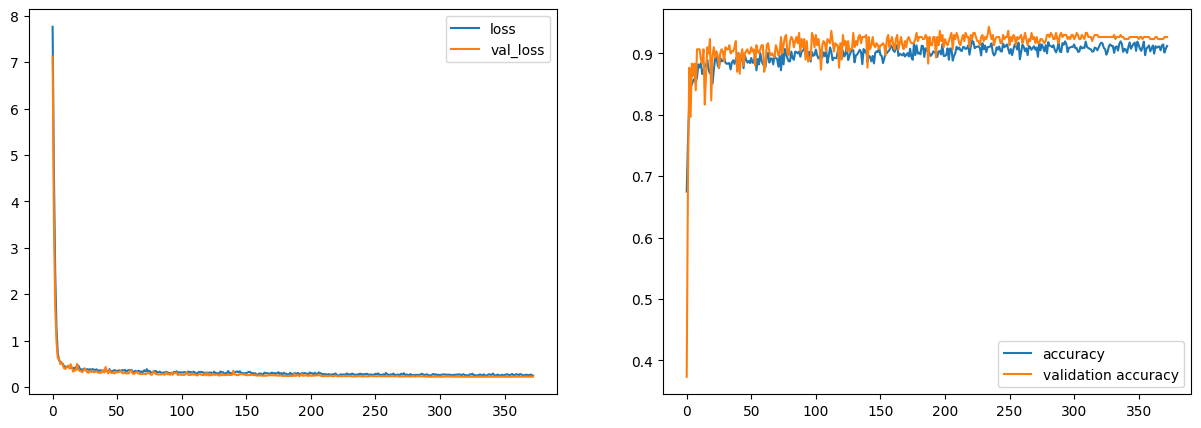

75/75 [==============================] - 0s 5ms/step - loss: 0.2442 - accuracy: 0.9121 - val_loss: 0.2251 - val_accuracy: 0.9267 - lr: 1.0000e-05
Epoch 373: early stopping


In [173]:
# Fitting the model
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val), callbacks=callback_list)

# Returning the best model
best_model = load_model("best_model.keras")

In [174]:
# Using the best model for evaluation
model = best_model

# Comparing the model's loss/accuracy/evaluation values between train and test
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

# They seem quite close luckily

Test data evaluation:


[0.18805795907974243, 0.9399999976158142]

Train data evaluation:
[0.19836586713790894, 0.9383333325386047]


10/10 [==============================] - 0s 1ms/step


<Axes: >

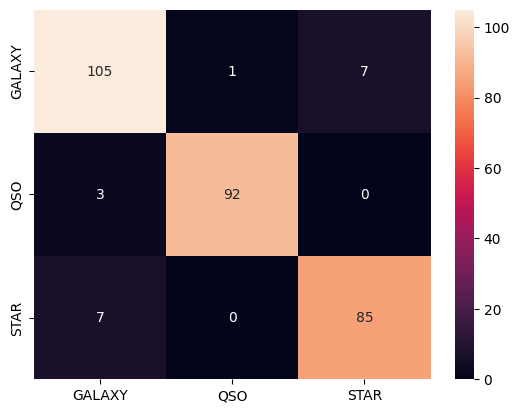

In [175]:
# Getting model predictions for all classes
# Then choosing the category with the highest predicted likelihood
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# Converting also y_test
y_test = np.argmax(y_test, axis=1)

# Confusion matrix heatmap with category names
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [176]:
# Classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# Printing overall accuracy of the model in a nicer format
acc = accuracy_score(y_test, test_predictions)
print("\nOverall model accuracy: {:.2f}%".format(acc * 100))

# Computing the ROC-AUC -score
print("ROC-AUC-score: {}".format(round(roc_auc_score(y, model.predict(X_sc), multi_class="ovr"), 5)))

              precision    recall  f1-score   support

      GALAXY       0.91      0.93      0.92       113
         QSO       0.99      0.97      0.98        95
        STAR       0.92      0.92      0.92        92

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300


Overall model accuracy: 94.00%
94/94 [==============================] - 0s 989us/step
ROC-AUC-score: 0.98915


I am quite happy with this, 95% overall accuracy and 0.99 ROC-AUC score seems decent and are a slight improvement over the basic version.
Still, when thinking about the pairplots before, especially looking at the redshift,
I can't help but think that it should be quite easy to separate the classes with almost 100% accuracy.
Maybe a SVM or other ML algorithm could do better here than a neural network.

In [177]:
# Making own predictions

# For test predictions with imaginary data
# it is important to know what kind of values the features usually take in the data

# Looking at the descriptions of data based on class:
# Galaxies have a mean redshift of 0.42 with max value 2
# Quasars have a mean redshift of 1.72 with max 7
# Stars all have 0 redshift
# Which is not true, but just a flaw of the data
# Since stars with noticeable redshift are so far away that they are almost impossible to record
# So they are just not represented in the data
# Of course galaxies are massive and contain a lot of things, so we can spot ones very far away
# And quasars are extreme objects that we can detect a huge distance away
# Thus redshift mostly just gives us an idea about the distance we can detect the object
# and how rare they are (there are very few quasars, so ones close to us with low redshift are rare)

# The other values all look really similarly distributed, so I feel like there almost isn't much of a point to come up with imaginary data here
# Redshift is by far the most important factor, so logically when dropping it, the model gets a lot worse
# Although interestingly, I still got accuracies between 70-80%, meaning that these other variables relate to the classes
columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

# Custom test row if desired (only works if no feature scaling is applied)
# test_row = {
#     'alpha': 140, 
#     'delta': 35, 
#     'u': 25, 
#     'g': 23, 
#     'r': 20, 
#     'i': 20, 
#     'z': 19,
#     'redshift': 4
# }

# Instead of making own predictions, I think it makes more sense here to 
# take a random sample from the dataset
# and see what the model says vs. the actual class

if feature_scaling == "normalization":
    df[columns] = MinMaxScaler().fit_transform(df[columns])
elif feature_scaling == "standardization":
    df[columns] = StandardScaler().fit_transform(df[columns])

# Taking a random sample
random_sample = df.sample()

# Saving the actual class
correct_class = random_sample["class"].values[0]

# input variables
test_row = random_sample[columns].to_dict(orient='records')[0]

# and row index
row_number = random_sample.index.values[0]


# convert to pandas-format
tester_row = pd.DataFrame([test_row])
print(tester_row)
result = model.predict(tester_row)[0]


result_index = np.argmax(result)

# print the category name from its index
result_text = categories[result_index]

# print the result
print(f"Row {row_number} was randomly selected from the dataset:\n{test_row}")
print("------------------------------")
print("Model prediction:\n")
for i, category in enumerate(categories):
    print(f"The model predicts {round(result[i]*100, 2)}% chance for class {category}.")
print(f"\nPredicted star class: {result_text}")
print(f"Correct star class: {correct_class}")

   alpha  delta     u     g     r     i     z  redshift
0  24.70   4.41 19.48 19.40 19.14 19.14 19.18      1.18
1/1 [==============================] - 0s 21ms/step
Row 28760 was randomly selected from the dataset:
{'alpha': 24.6978645870662, 'delta': 4.40738355576746, 'u': 19.47928, 'g': 19.3995, 'r': 19.13837, 'i': 19.14236, 'z': 19.18406, 'redshift': 1.178101}
------------------------------
Model prediction:

The model predicts 0.23% chance for class GALAXY.
The model predicts 99.73% chance for class QSO.
The model predicts 0.04% chance for class STAR.

Predicted star class: QSO
Correct star class: QSO
